[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/GNN/blob/main/GCN.ipynb)

# Determining Molecule Solubility using GCN

In [ ]:
!pip install rdkit
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
from torch_geometric.datasets import MoleculeNet # importing molecule-net from torch_geometric
data = MoleculeNet(root=".", name="ESOL") # loading the ESOL dataset from molecule-net

Processing...
Done!


In [ ]:
# Investigating the dataset
print("Node Feature Vector Size : ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Total no. of molecules present in the dataset : ", data.len)

Node Feature Vector Size :  9
Dataset target:  734
Total no. of molecules present in the dataset :  <bound method InMemoryDataset.len of ESOL(1128)>


Smiles Code for Molecule 0 :  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


Graphical Representation of Molecule 0 : 


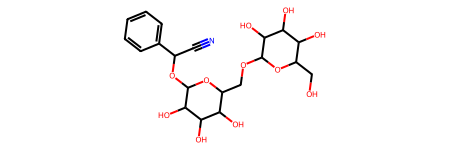

In [ ]:
# Visualizing first molecule in the dataset
print("Smiles Code for Molecule 0 : ", data[0]["smiles"])
print("")
print("")


from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
print("Graphical Representation of Molecule 0 : ")
Chem.MolFromSmiles(data[0]["smiles"])

In [ ]:
# Investingating first molecule in the dataset
print("Solubility of Molecule 0 : ", data[0].y)
print("")
print("")


print("No. of nodes in Molecule 0 : ", data[0].num_nodes)
print("Feature vector for each node in molecule 0 : ", data[0].x) # Shape: [num_nodes, num_node_features] = [32, 9]
print("")
print("")


print("No. of edges in Molecule 0 : ", data[0].num_edges)
print("Feature vector for each edge in molecule 0 : ", data[0].edge_index.t()) # Shape [2, num_edges] = [2,68]
print("")
print("")


print("Molecule 0 : ", data[0])

Solubility of Molecule 0 :  tensor([[-0.7700]])


No. of nodes in Molecule 0 :  32
Feature vector for each node in molecule 0 :  tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5,

# Dataloader

In [ ]:
from torch_geometric.data import DataLoader
loader = DataLoader(data[:int(len(data) * 0.8)], batch_size=64, shuffle=True) # train loader - 80%
test_loader = DataLoader(data[int(len(data) * 0.8):], batch_size=64, shuffle=True) # test loader - 20%

# Modelling
Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

In [ ]:
import torch
from torch.nn import Linear, BatchNorm1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TransformerConv, GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

In [ ]:
class Custom_GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats = Tensor with node features of shape[batch_size, num_nodes, c_in]
            adj_matrix = Batch adjacency matrix of the graph
            shape:[batch_size, num_nodes, num_nodes]
        """

        #num_neighbors = number of incoming edges
        num_neighbors = adj_matrix.sum(dim = -1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbors
        return node_feats

In [ ]:
class Global_GCN(torch.nn.Module):

    def __init__(self):

        # Init parent
        super(Global_GCN, self).__init__()
        embedding_size = 64 # we can change this to any number

        # Input GCN layers
        self.gcn1 = GCNConv(data.num_features, embedding_size)
        '''
        instead of these pytorch GCNConv layer we can also use
        Custom_GCNLayer that I have written above
        '''

        # Hidden GCN Layers = 3 , we can add as many as needed
        self.gcn2 = GCNConv(embedding_size, embedding_size)
        self.gcn3 = GCNConv(embedding_size, embedding_size)
        self.gcn4 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1) # because a regression problem

    def forward(self, x, edge_index, batch_index):

        # GCN 1
        hidden = self.gcn1(x, edge_index)
        hidden = F.tanh(hidden)

        # GCN 2
        hidden = self.gcn2(hidden, edge_index)
        hidden = F.tanh(hidden)

        # GCN 3
        hidden = self.gcn3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # GCN 4
        hidden = self.gcn4(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Concatenate ( Global_MAX_pooling(all nodes) , Global_AVERAGE_pooling(all nodes) )
        hidden = torch.cat([ gmp(hidden, batch_index), gap(hidden, batch_index) ], dim=1)

        # Apply a final regression layer.
        out = self.out(hidden)

        return out

# Training

In [ ]:
model = Global_GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Global_GCN(
  (gcn1): GCNConv(9, 64)
  (gcn2): GCNConv(64, 64)
  (gcn3): GCNConv(64, 64)
  (gcn4): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [ ]:
loss_fn = torch.nn.MSELoss() # root mean squared error cause regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
model = model.to(device)
losses = []

In [ ]:
for epoch in range(2000):

    for batch in loader:

      batch.to(device) # sending data to GPU

      optimizer.zero_grad() # Reset gradients

      pred = model(batch.x.float(), batch.edge_index, batch.batch) # Passing the node features and the connection info

      loss = loss_fn(pred, batch.y) # Calculating the loss and gradients

      loss.backward()

      optimizer.step() # Update using the gradients

    losses.append(loss)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Epoch 0 | Train Loss 11.665946006774902
Epoch 100 | Train Loss 0.8498162031173706
Epoch 200 | Train Loss 1.1210112571716309
Epoch 300 | Train Loss 0.3183463215827942
Epoch 400 | Train Loss 0.23326805233955383
Epoch 500 | Train Loss 0.3861334025859833
Epoch 600 | Train Loss 0.24146506190299988
Epoch 700 | Train Loss 0.06126975640654564
Epoch 800 | Train Loss 0.15942007303237915
Epoch 900 | Train Loss 0.16325688362121582
Epoch 1000 | Train Loss 0.06017620116472244
Epoch 1100 | Train Loss 0.04900476336479187
Epoch 1200 | Train Loss 0.11288391053676605
Epoch 1300 | Train Loss 0.05834909528493881
Epoch 1400 | Train Loss 0.02961779199540615
Epoch 1500 | Train Loss 0.024113871157169342
Epoch 1600 | Train Loss 0.023395266383886337
Epoch 1700 | Train Loss 0.007630868814885616
Epoch 1800 | Train Loss 0.06328804790973663
Epoch 1900 | Train Loss 0.11817934364080429


# Single Batch Inference































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-4.173,-3.074911
1,-1.300,-3.074911
2,-2.180,-3.074911
3,-0.660,-3.074911
4,-1.960,-3.074911
...,...,...
59,-4.522,-3.074911
60,-1.520,-3.074911
61,0.020,-3.074911
62,-2.518,-3.074911
